# <h1><center>Central Pattern Generator Tutorial</center></h1>

This notebook provides an introductory tutorial to the usage of Central Pattern Generators (CPG) for robotic locomotion.
Specifically, we cover the bio-inspired origin of CPGs and how they can be implemented using differential equations. Furthermore, we show how these differential equations can be solved numerically using Jax.

## Central Pattern Generators
Central Pattern Generators (CPGs) are neural circuits that produce rhythmic patterned outputs without requiring rhythmic input. The term 'central' indicates that sensory feedback (from the peripheral nervous system) is not needed for generating the rhythms. This intrinsic capability to produce rhythmic patterns is essential for many basic life functions such as chewing, breathing, and digesting. They are also fundamental building blocks for the locomotor neural circuits both in invertebrate and vertebrate animals. CPGs present several interesting properties such as distributed control, the ability to deal with redundancies, fast control loops, and allowing modulation of the rhythmic patterns with simple control signals. These properties make CPGs interesting building blocks for locomotion controllers in robotics. 

Two primary approaches are prevalent in the implementation of Central Pattern Generators (CPGs) in robotics: the connectionist approach and the differential equations approach. Both rely on the creation of a nonlinear dynamical system.

The connectionist approach involves creating CPGs through networks of interconnected artificial neurons (resulting in a recurrent neural network). The connectionist model is particularly effective for simulating adaptive behaviors, as it can learn and modify its connections based on feedback, much like a biological neural network. In essence, the connectionist approach relies on the Universal Approximation theorem of neural networks to provide a way to optimize towards any kind of rhythmic output. This approach is often employed when the targeted CPG properties cannot be modelled mathematically.
 
On the other hand, the differential equations approach uses mathematical models based on differential equations to simulate the rhythmic outputs of CPGs. This method relies on carefully crafted equations that describe the dynamics of the system, often focusing on the interactions between different elements of the CPG and their temporal evolution. This approach is particularly valued for its precision and predictability, allowing for a detailed understanding of the underlying mechanics of rhythmic patterns. It is widely used in more traditional engineering and robotics contexts, where precise control and predictability are essential. In essence, we can enforce specific properties of rhythmic output we desire though crafting the differential equations.

In this tutorial, we will focus on the latter approach.

## Differential equations
Before diving into an actual CPG implementation, we will take a brief side step and recap what differential equations are and what they are used for.

Differential equations are mathematical equations that describe the relationship between a function and its derivatives. They are fundamental in expressing how a quantity changes over time or space and are pivotal in modeling the behavior of diverse physical, biological, chemical, and economic systems. At their core, differential equations involve functions and their rates of change. For example, in physics, they are used to describe phenomena like the motion of a pendulum or the flow of heat in a solid. In biology, they can model population dynamics or the spread of diseases. In engineering, differential equations are crucial for designing control systems or understanding the behavior of electrical circuits. There are two main types of differential equations: ordinary differential equations (ODEs) and partial differential equations (PDEs). ODEs involve functions of a single variable and their derivatives, such as time. PDEs, on the other hand, deal with functions of multiple variables and their partial derivatives, like space and time. Solving a differential equation typically means finding the function or set of functions that satisfy the equation. The solutions can provide vital insights into the behavior of the system being modeled, predicting how it evolves over time or reacts to different conditions. Due to the complexity of many differential equations, solutions are often sought through numerical methods, especially for equations that cannot be solved analytically.

### Case study
Given our use of physics simulators, we will use a related example. Physics simulators rely on differential equations to accurately represent the dynamics of real-world phenomena. Differential equations enable the simulation of a wide array of physical processes, such as the motion of objects under the influence of forces, fluid dynamics, and even changes in temperature and energy. The motion of objects is often governed by Newton's laws of motion, which are expressed through differential equations. For example, the change in velocity (i.e. the acceleration) of an object is calculated based on the forces applied to it, encapsulating the principles of mass, force, and acceleration. Similarly, in simulating fluid dynamics, the Navier-Stokes equations – a set of nonlinear partial differential equations – are used to describe the motion of fluid substances. These simulators numerically solve these differential equations at discrete time intervals. Ultimately, physics simulators thus solve differential equations to predict the state of the system at a future point in time, given the current state (i.e. the initial/current conditions of the system).

In this case study, we will solve the differential equations that describe the motion of a point in one-dimensional space. As stated above, the motion of objects is often described by Newton's laws of motion: $F = ma$ (the second law). This law links the force $F$ we apply to an object to its mass $m$ and acceleration $a$. As you you know, acceleration $a$ is the derivative of velocity $v$ with respect to time $t$, which again is the derivative of position $p$ with respect to time. This law can thus be rewritten as $F = ma = m v' = m p''$, where $'$ denotes the derivative.

To simplify things, let's say that in our one-dimensional space, we only have a single force that acts upon the object, which we completely control. We thus know $F(t)$. We will also give our object a mass of 1 such that we can remove it from the above equations: $F = a = v' = p''$. So given a function that describes our force over time $F(t)$, we immediately know what the acceleration $a$ of our point will be. But what if we want to know the velocity over time $v(t)$? Let's work this out with a force function $F(t) = t^2$.

In [27]:
import chex
import numpy as np


def force(
        time: float
        ) -> float:
    return time ** 2


def acceleration(
        time: float,
        velocity: float
        ) -> float:
    # F = ma
    mass = 1
    return mass * force(time=time)

Note: the reason why the acceleration function also takes the velocity as an argument, is because the general form of an ODE is $y'(t) = f(t, y(t))$, i.e. the derivative of a function is a function of the independent variable and the function itself. In our case, this means that $a(t) = v'(t) = f'(t, v(t)$. So while we do not explicitly use the velocity in the calculation of our acceleration, let's keep it as an argument anyway to stay general.

Anyway, we know that $a = v'$, i.e. the derivative of our velocity with respect to time is equal to the acceleration. This means that the acceleration function describes how our velocity changes over time. If we were given the current velocity as an initial condition, i.e. $v(t_n)$, we can thus calculate $v(t_{n+1})$ by just taking a small steps in the direction of the acceleration.

In [28]:
def get_next_velocity(
        current_time: float,
        current_velocity: float,
        delta_time: float
        ) -> float:
    current_acceleration = acceleration(time=current_time, velocity=current_velocity)
    new_velocity = current_velocity + delta_time * current_acceleration
    return new_velocity

Let's use this to simulate a trajectory of `simulation_time` seconds with our point, starting from $v(t_0) = 0$.

In [29]:
simulation_time = 10
delta_time = 0.01

times = [0]
velocities = [0]

while times[-1] < simulation_time:
    next_velocity = get_next_velocity(current_time=times[-1], current_velocity=velocities[-1], delta_time=delta_time)
    velocities.append(next_velocity)
    times.append(times[-1] + delta_time)

Time to write a visualization function

In [30]:
from matplotlib import pyplot as plt


def visualize_trajectory(
        times: np.ndarray,
        quantity: np.ndarray,
        quantity_label: str,
        color: str = "blue",
        flush: bool = True
        ) -> None:
    plt.plot(times, quantity, color=color, label=quantity_label)
    if flush:
        plt.xlabel("time")
        plt.legend()
        plt.show()
        plt.close()

Now we can visualize our velocity over time.

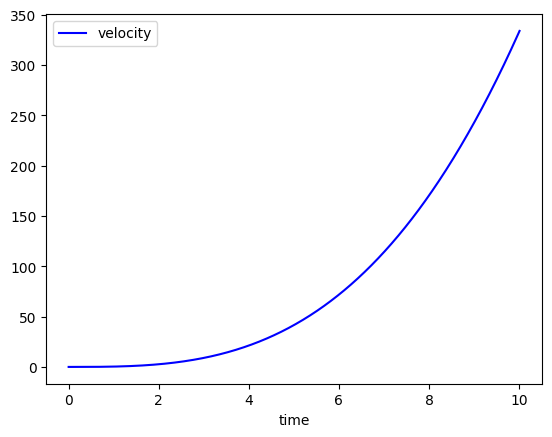

In [31]:
visualize_trajectory(times=times, quantity=velocities, quantity_label="velocity")

This is quite as expected. Our force function is $F(t) = t^2$. As discussed above, our point's acceleration $a$ follows this same function (given that we used a mass $m$ of 1). So we actually solved the ODE $a = v'$. This methodology, i.e. starting from a known initial condition and iteratively taking a small step in the direction of the derivative function (which actually represents the slope of the original function at that point) is known as the [Euler method](https://en.wikipedia.org/wiki/Euler_method).

### Euler method
Before moving on, let's first implement our Euler 'solver' in a more general manner.

In [32]:
from typing import Callable


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y

It's important to remember that we're actually approximating the velocity function numerically, instead of getting an exact solution. In this specific ODE where we have $v'(t) = a(t) = t^2$ and $v(0) = 0$, we can easily see that $v(t) = \frac{1}{3}t^3$ is the exact solution (plug this into the ODE to check). See what happens if we try some different `delta_time` values (i.e. different step sizes) and compare it to this exact solution.

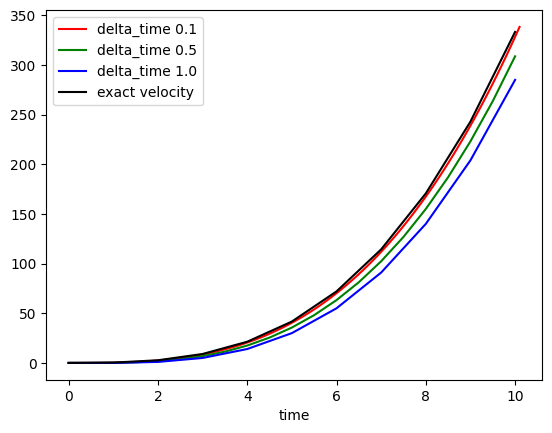

In [33]:
simulation_time = 10
delta_times = [0.1, 0.5, 1.0]
colors = ["red", "green", "blue"]

for delta_time, color in zip(delta_times, colors):
    times = [0]
    velocities = [0]

    while times[-1] < simulation_time:
        next_velocity = euler_solver(
                current_time=times[-1], y=velocities[-1], derivative_fn=acceleration, delta_time=delta_time
                )
        velocities.append(next_velocity)
        times.append(times[-1] + delta_time)
    visualize_trajectory(
            times=times, quantity=velocities, quantity_label=f"delta_time {delta_time}", color=color, flush=False
            )

exact_solution = 1 / 3 * np.power(np.array(times), 3)
visualize_trajectory(times=times, quantity=exact_solution, quantity_label="exact velocity", color="black", flush=True)

We can see that the smaller our step size, the better the approximation! This is because we linearly approximate the change of our function $v(t)$ over time (by taking a step in the direction of our slope at each point), while the true change of our function (in this case $a(t) = t^2$) is non-linear! This approximation only remains sufficiently close to the true solution if we take small enough steps, at the cost of more computation.

Sidenote: When you solve an ODE, you are essentially integrating the differential equation. The ODE describes the change over time, integrating this change over time (i.e. taking a 'sum' of all change over time), gives us the current 'state' at each time. 

This Euler method is a member of the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). The Euler method is the simplest form of the Runge-Kutta methods and can be considered a first-order Runge-Kutta method. As shown above, it approximates the solution of an ODE by taking a series of steps along the curve, using the slope of the curve (derived from the ODE) at the beginning of each step to predict the value of the function at the next step. The process is akin to taking small, linear steps along the curve, each step based only on the immediate slope. In contrast, higher-order Runge-Kutta methods, such as the popular fourth-order Runge-Kutta method (RK4), take a more sophisticated approach. They use multiple evaluations of the slope (derivative) at various points within each step to make a more accurate prediction for the next value. These methods effectively use additional information about the curvature and behavior of the function within each step to refine their predictions. So at the cost of more function evaluations, it provides better slope approximations.

### Runge-Kutta methods
Let's implement an RK4 solver (4 refers to 4 slope approximations via 4 derivative function evaluations).

In [34]:
def rk4_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    # This is the original euler
    slope1 = derivative_fn(current_time, y)
    # These are additional slope calculations that improve our approximation of the true slope  
    slope2 = derivative_fn(current_time + delta_time / 2, y + slope1 * delta_time / 2)
    slope3 = derivative_fn(current_time + delta_time / 2, y + slope2 * delta_time / 2)
    slope4 = derivative_fn(current_time + delta_time, y + slope3 * delta_time)
    average_slope = (slope1 + 2 * slope2 + 2 * slope3 + slope4) / 6
    next_y = y + average_slope * delta_time
    return next_y

Let's compare the euler and RK4 approximations!

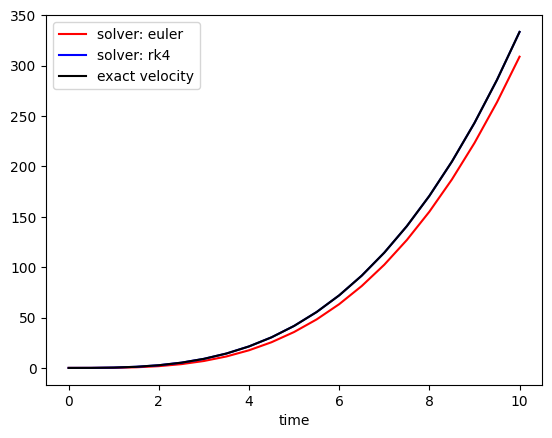

In [35]:
simulation_time = 10
delta_time = 0.5
solvers = [euler_solver, rk4_solver]
solver_names = ["euler", "rk4"]
colors = ["red", "blue"]

for solver, solver_name, color in zip(solvers, solver_names, colors):
    times = [0]
    velocities = [0]

    while times[-1] < simulation_time:
        next_velocity = solver(
                current_time=times[-1], y=velocities[-1], derivative_fn=acceleration, delta_time=delta_time
                )
        velocities.append(next_velocity)
        times.append(times[-1] + delta_time)
    visualize_trajectory(
            times=times, quantity=velocities, quantity_label=f"solver: {solver_name}", color=color, flush=False
            )

exact_solution = 1 / 3 * np.power(np.array(times), 3)
visualize_trajectory(times=times, quantity=exact_solution, quantity_label="exact velocity", color="black", flush=True)

As you can see, our RK4 solver solves the ODE better than our orignal Euler (which could also be written as RK1). We can even say that the RK4 solver provides an exact solution to the ODE because if the exact solution to the differential equation is a polynomial of order $n$, it will be solved exactly by an $n$-th order Runge-Kutta method. The slope approximations that appear in the RK$n$ methods are based on a Taylor series approximation of the true slope. Diving into that is a bit out of scope for this tutorial, but feel free to head to dive a little bit deeper yourself.

### Second-order differential equations 
The velocity and acceleration example from above is an example of a first-order ODE (i.e. the highest order of a derivative in the ODE is one). We used the euler and RK4 methods to solve for the velocity $v(t)$ given an acceleration function $a(t)$. If we now want to find our point's position $p(t)$ over time, we get the following second-order ODE: $a(t) = p''(t)$. The nice thing is that we can reuse or previous solution to do so! Since we already solved the $a(t) = v'(t)$, we know the (approximated) value of the velocity function $v(t)$. So we can just solve another first order ODE instead: $v(t) = p'(t)$!


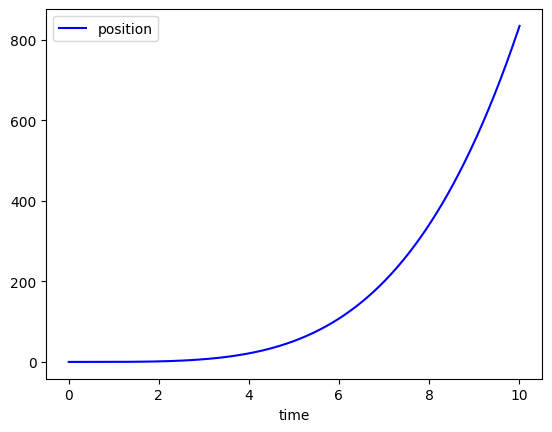

In [36]:
times = [0]
positions = [0]
velocities = [0]
delta_time = 0.01

while times[-1] < 10:
    next_velocity = rk4_solver(
            current_time=times[-1], y=velocities[-1], derivative_fn=acceleration, delta_time=delta_time
            )
    next_position = rk4_solver(
            current_time=times[-1],
            y=positions[-1],
            derivative_fn=lambda
                t,
                p: velocities[-1],
            delta_time=delta_time
            )
    times.append(times[-1] + delta_time)
    positions.append(next_position)
    velocities.append(next_velocity)

visualize_trajectory(times=times, quantity=positions, quantity_label="position")

Knowing that $v(t) = \frac{1}{3}t^3$ and that $v(0) = 0$, we can again see that the exact solution would be $p(t) = \frac{1}{3 * 4}t^4$. Let's compare our previous result to the exact solution as a validation.

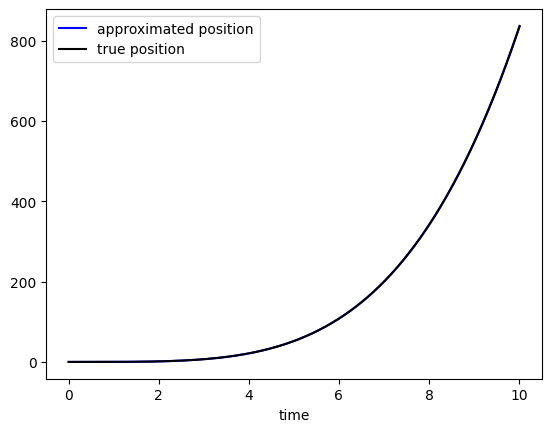

In [37]:
visualize_trajectory(times=times, quantity=positions, quantity_label="approximated position", flush=False)
exact_solution = 1 / 12 * np.power(times, 4)
visualize_trajectory(times=times, quantity=exact_solution, quantity_label="true position", color="black", flush=True)

Solving a second-order ODE thus comes down to solving two first-order ODEs. We solved $p'' = a = t^2$ with initial conditions $p(0) = 0, p'(0) = v(0) = 0$. We did this by first solving $v'(t) = t^2$ with the initial condition $v(0) = 0$. Every step, this gives us $v(t_{n+1}})$
Then we solve $p(t)' = v(t)$ with the initial condition $p(0) = 0$. In every step, we approximate $v(t)$ as a constant, given that we calculated it in the previous step (or know it as an initial condition due to $p'(0) = v(0)$ being given).

In a more general form, let's say we we have a second-order ODE: $y'' + y' + y = c$  with initial conditions $y(0) = a, y'(0) = b$
If we let $y_1 = y$ and $y_2 = y'$, we can write the original second-order ODE as a system of two first-order ODEs:
$\begin{bmatrix} y_1' \\ y_2'\end{bmatrix} = \begin{bmatrix} y_2 \\ c - y_1 - y_2\end{bmatrix}$ with initial conditions: $\begin{bmatrix} y_1(0) \\ y_2(0)\end{bmatrix} = \begin{bmatrix} a \\ b\end{bmatrix}$. In this manner, we can use our first-order ODE solvers to solve second-order ODEs (and even higher order ODEs) by decomposing them.

Note: although our case study focused on solving ordinary differential equations, the same methodology can be employed for partial differential equations.

## Implementing a Central Pattern Generator

Now that we refreshed our intuition with respect to using and solving differential equations, we can finally move on to the actual implementation of a CPG. We will implement the CPG model used in a paper by [Sproewitz et al](https://journals.sagepub.com/doi/10.1177/0278364907088401). This CPG model is implemented as a system of $N$ coupled amplitude- and offset-controlled phase oscillators. An oscillator $i$ is defined by the following differential equations (the $\dot$ refers to the derivative operator, which we previously used $`$ for): 

(1) $\dot{\phi_i} = \omega_i + \sum_j{w_{ij}r_j}\sin{(\phi_j - \phi_i - \rho_{ij})}$<br>
(2) $\ddot{r_i} = a_r(\frac{a_r}{4}(R_i - r_i) - \dot{r_i})$<br>
(3) $\ddot{x_i} = a_x(\frac{a_x}{4}(X_i - x_i) - \dot{x_i})$<br>
(4) $\theta_i = x_i + r_i\cos{(\phi_i)}$<br>

where $\theta_i$ is the output of the oscillator (in radians) and $\phi_i$ , $r_i$ and $x_i$ are state variables that respectively encode the phase, amplitude and the offset of the oscillations. The parameters $\omega_i$ , $R_i$ and $X_i$ are control parameters for the desired frequency, amplitude and offset of the oscillations. The parameters $w_{ij}$ and $\rho_{ij}$ are respectively the coupling weights and phase biases, which determine how oscillator $j$ influences oscillator $i$. The parameters $a_r$ and $a_x$ are constant positive gains.

These equations were designed such that the output of the oscillator $i$ exhibits limit cycle behavior, i.e. produces a stable periodic output. Equation (1) determines the time evolution of the phases of the oscillators, i.e. the phase frequency ("in which direction and how fast should the phase change?"). The sum term represents the coupling with other oscillators.   

Similar to the paper, we will use the same frequency parameter $\omega_i = \omega$ for all oscillators, and bi-directional couplings between oscillators such that $\rho_{ij} = -\rho_{ji}$. We also ensure that, in case of a closed loop of inter-oscillator couplings, all phase biases in the loop are consistent (i.e. sum to a multiple of $2\pi$). With these parameters, the phases will converge to a regime in which they grow linearly with a common rate $\omega$ and with a phase difference between oscillators determined by $\rho_{ij}$. Equations (2) and (3) are critically damped second-order [linear differential equations](https://en.wikipedia.org/wiki/Linear_differential_equation) which respectively have $R_i$ and $X_i$ as stable fixed points. This means that from any initial conditions, the state variables $r_i$ and $x_i$ will asymptotically and monotonically converge to $R_i$ and $X_i$. This allows one to smoothly modulate the amplitude and offset of oscillations.

With these settings, two oscillators $i$ and $j$ that are coupled with non-zero weights $w_{ij}$ asymptotically converge to limit cycles (i.e. a closed trajectory in the state space that corresponds to sustained oscillations without decay or growth) $\Theta_i^\infty$ and $\Theta_j^\infty$ with the following closed form (i.e. exact) solutions:

$\Theta_i^\infty = X_i + R_i\cos{(\omega t + \rho_{ij} + \phi_0)}$<br>
$\Theta_j^\infty = X_j + R_j\cos{(\omega t + \rho_{ji} + \phi_0)}$<br>
where $\phi_0$ depends on the initial conditions of the system. Note that, because of the common frequency $\omega$ and phase biases $\phi_{ij}$ in a loop, this behaviour does not depend on the coupling weights $w_{ij}$. The coupling weights only affect how quickly the system converges: the larger the weights, the faster the convergence. This means that the system stabilizes into oscillations that are phase-locked for all oscillators that are connected together. These oscillations can be modulated (i.e. controlled) by several control parameters, $\omega$ for setting a common frequency, $\rho_{ij}$ for setting the phase lags between two connected oscillators, $R_i$ for setting the individual amplitudes and $X_i$ for setting the individual offsets.

This CPG model has several nice properties:
1. The system exhibits limit cycle behavior, i.e. oscillations rapidly return to the steady-state oscillations after any transient perturbation of the state variables
2. This limit cycle has a closed form solution. Most types of oscillators used to build CPGs do not have a closed form solution for their limit cycle. The limit cycle has a harmonic shape and has control parameters ($\omega$, $R_i$ and $X_i$) that are explicit and are directly related to relevant features of the oscillations. This facilitates the design and analysis of locomotion controllers. 
3. A third interesting property is that these control parameters can be abruptly and/or continuously varied while inducing only smooth changes in the resulting oscillations (i.e. there are no discontinuities nor jerks). This property is important in avoiding damage in the motors and gearboxes of robots.

Let's now implement this model for a system with 2 bi-directionally coupled oscillators in JAX. We will implement this using a functional CPG class and a datastructures for the CPG's state. 

In [38]:
import functools
from flax import struct
import jax
import jax.numpy as jnp
import chex


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray

    # We'll make these modulatory parameters part of the state as they will change as well
    R: jnp.ndarray
    X: jnp.ndarray
    omegas: jnp.ndarray
    rhos: jnp.ndarray


class CPG:
    def __init__(
            self,
            weights: jnp.ndarray,
            amplitude_gain: float = 20,
            offset_gain: float = 20,
            dt: float = 0.01,
            solver: str = "euler"
            ) -> None:
        self._weights = weights
        self._amplitude_gain = amplitude_gain
        self._offset_gain = offset_gain
        self._dt = dt
        assert solver in ["euler", "rk4"], f"'solver' must be one of ['euler', 'rk4']"

        if solver == "euler":
            self._solver = euler_solver
        else:
            self._solver = "rk4"

    @property
    def num_oscillators(
            self
            ) -> int:
        return self._weights.shape[0]

    @staticmethod
    def phase_de(
            weights: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray,
            phase_biases: jnp.ndarray,
            omegas: jnp.ndarray
            ) -> jnp.ndarray:
        @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
        def sine_term(
                phase_i: float,
                phase_biases_i: float
                ) -> jnp.ndarray:
            return jnp.sin(phases - phase_i - phase_biases_i)

        couplings = jnp.sum(weights * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
        return omegas + couplings

    @staticmethod
    def second_order_de(
            gain: jnp.ndarray,
            modulator: jnp.ndarray,
            values: jnp.ndarray,
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:

        return gain * ((gain / 4) * (modulator - values) - dot_values)

    @staticmethod
    def first_order_de(
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return dot_values

    @staticmethod
    def output(
            offsets: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray
            ) -> jnp.ndarray:
        return offsets + amplitudes * jnp.cos(phases)

    def reset(
            self,
            rng: chex.PRNGKey
            ) -> CPGState:
        phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
        # noinspection PyArgumentList
        state = CPGState(
                phases=jax.random.uniform(
                        key=phase_rng, shape=(self.num_oscillators,), dtype=jnp.float32, minval=-0.01, maxval=0.01
                        ),
                amplitudes=jnp.zeros(self.num_oscillators),
                offsets=jnp.zeros(self.num_oscillators),
                dot_amplitudes=jnp.zeros(self.num_oscillators),
                dot_offsets=jnp.zeros(self.num_oscillators),
                outputs=jnp.zeros(self.num_oscillators),
                time=0.0,
                R=jnp.zeros(self.num_oscillators),
                X=jnp.zeros(self.num_oscillators),
                omegas=jnp.zeros(self.num_oscillators),
                rhos=jnp.zeros_like(self._weights)
                )
        return state

    @functools.partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: CPGState, ) -> CPGState:
        # Update phase
        new_phases = solver(
                current_time=state.time,
                y=state.phases,
                derivative_fn=lambda
                    t,
                    y: self.phase_de(
                        omegas=state.omegas,
                        amplitudes=state.amplitudes,
                        phases=y,
                        phase_biases=state.rhos,
                        weights=self._weights
                        ),
                delta_time=self._dt
                )
        new_dot_amplitudes = solver(
                current_time=state.time,
                y=state.dot_amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._amplitude_gain, modulator=state.R, values=state.amplitudes, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_amplitudes = solver(
                current_time=state.time,
                y=state.amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_amplitudes),
                delta_time=self._dt
                )
        new_dot_offsets = solver(
                current_time=state.time,
                y=state.dot_offsets,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._offset_gain, modulator=state.X, values=state.offsets, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_offsets = solver(
                current_time=0,
                y=state.offsets,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_offsets),
                delta_time=self._dt
                )

        new_outputs = self.output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
        # noinspection PyUnresolvedReferences
        return state.replace(
                phases=new_phases,
                dot_amplitudes=new_dot_amplitudes,
                amplitudes=new_amplitudes,
                dot_offsets=new_dot_offsets,
                offsets=new_offsets,
                outputs=new_outputs,
                time=state.time + self._dt
                )

Time to test! To validate the CPG implementation, it's always a good idea to visualize its output. We'll do that here, and we'll also visualize the phases of the two oscillators. 

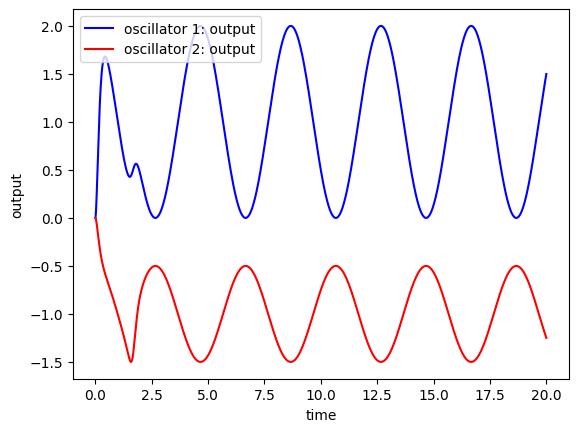

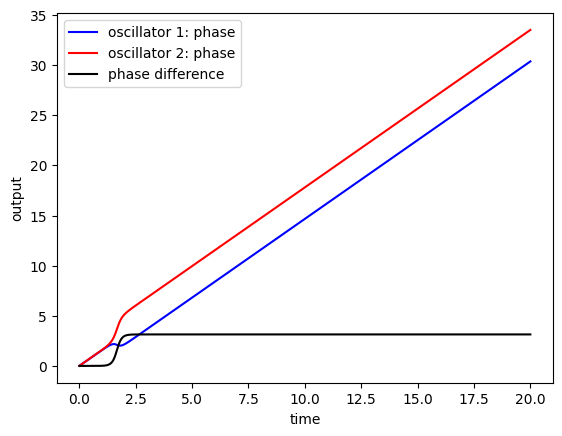

In [39]:
rng = jax.random.PRNGKey(seed=0)

adjacency_matrix = jnp.ones((2, 2)) - jnp.identity(2)
weights = 5 * adjacency_matrix
cpg = CPG(weights=weights, amplitude_gain=20, offset_gain=20, dt=0.01, solver="euler")

cpg_state = cpg.reset(rng=rng)

# Set modulation parameters
cpg_state = cpg_state.replace(
        R=jnp.array([1.0, 0.5]),
        X=jnp.array([1.0, -1.0]),
        omegas=(jnp.pi / 2) * jnp.ones(cpg.num_oscillators),
        rhos=adjacency_matrix * jnp.array([[jnp.pi], [-jnp.pi]])
        )

SIMLATION_TIME = 20

# We'll save the states to visualize them at the end
states = []
while cpg_state.time < SIMLATION_TIME:
    cpg_state = cpg.step(
            cpg_state
            )
    states.append(cpg_state)

times = [state.time for state in states]
o1 = [state.outputs[0] for state in states]
o2 = [state.outputs[1] for state in states]

plt.plot(times, o1, color="blue", label="oscillator 1: output")
plt.plot(times, o2, color="red", label="oscillator 2: output")
plt.legend()
plt.xlabel("time")
plt.ylabel("output")
plt.show()
plt.close()

times = [state.time for state in states]
o1 = [state.phases[0] for state in states]
o2 = [state.phases[1] for state in states]

plt.plot(times, o1, color="blue", label="oscillator 1: phase")
plt.plot(times, o2, color="red", label="oscillator 2: phase")
plt.plot(times, np.array(o2) - np.array(o1), label="phase difference", color="black")
plt.legend()
plt.xlabel("time")
plt.ylabel("output")
plt.show()
plt.close()


Cool! Looking at the CPG outputs, we can indeed see that our oscillators (1) converge to a limit cycle (steady-state oscillations), even though we have random initial conditions, (2) the two oscillators indeed converge to the given target amplitudes $R_0=1$ and $R_1=0.5$, (3) the two oscillators indeed converge to the given target offsets $X_0=1$ and $X_1=-1$, and (4)  the two oscillators indeed exhibit our requested phase lag $\pi$, making them run in anti-phase. The latter is also demonstrated by the phases plot. We can see that the phase difference between the two oscillators converges to our phase bias setting: $\pi$, i.e. $\rho_{12} = \pi$ and $\rho_{21} = -\pi$. Due to the definition of the oscillator couplings in Equation $(1)$ above, this causes the oscillator one to decrease its phase frequency, and oscillator two to increase its phase frequency, until the desired bias (i.e. difference between them) of $\pi$ is met. 

Let's now see how our CPG reacts to intermediate modulations. What if we were to swap our amplitude and offset modulation parameters for both oscillators at $t=10$?

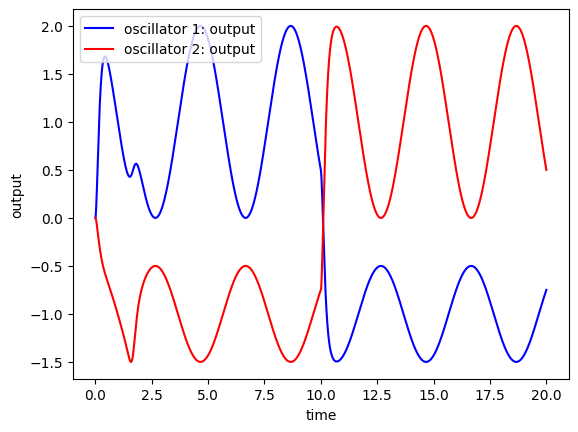

In [40]:
rng = jax.random.PRNGKey(seed=0)

adjacency_matrix = jnp.ones((2, 2)) - jnp.identity(2)
weights = 5 * adjacency_matrix
cpg = CPG(weights=weights, amplitude_gain=20, offset_gain=20, dt=0.01, solver="euler")

cpg_state = cpg.reset(rng=rng)

# Set modulation parameters
cpg_state = cpg_state.replace(
        R=jnp.array([1.0, 0.5]),
        X=jnp.array([1.0, -1.0]),
        omegas=(jnp.pi / 2) * jnp.ones(cpg.num_oscillators),
        rhos=adjacency_matrix * jnp.array([[jnp.pi], [-jnp.pi]])
        )

SIMLATION_TIME = 20

# We'll save the states to visualize them at the end
states = []
remodulated = False
while cpg_state.time < SIMLATION_TIME:
    cpg_state = cpg.step(
            cpg_state
            )
    states.append(cpg_state)

    if cpg_state.time > 10 and not remodulated:
        remodulated = True
        cpg_state = cpg_state.replace(
                R=jnp.array([0.5, 1.0]), X=jnp.array([-1.0, 1.0]), )

times = [state.time for state in states]
o1 = [state.outputs[0] for state in states]
o2 = [state.outputs[1] for state in states]

plt.plot(times, o1, color="blue", label="oscillator 1: output")
plt.plot(times, o2, color="red", label="oscillator 2: output")
plt.legend()
plt.xlabel("time")
plt.ylabel("output")
plt.show()
plt.close()

Cheers! Take some time to play around with these parameters now. A good way to get a better intuition into the usage of CPGs is to try to predict the influence of some parameter changes before running them. 

## Using the CPG to imitate the brittle star's rowing behaviour

Using a CPG for robot control comes down to defining a system of interconnected oscillators of which we pass the outputs to the actuators of the robot. Let's try to do this with our brittle star robot to imitate a real brittle star's rowing gait.

In [41]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Checking that the mujoco installation succeeded:
MuJoCo installation successful.


### Environment setup
We'll start by creating our environment. We'll use a brittle star robot with 5 arms and 5 segments per arm.

In [42]:
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from brb.brittle_star.environment.undirected_locomotion.dual import BrittleStarUndirectedLocomotionEnvironment
from brb.brittle_star.environment.undirected_locomotion.shared import \
    BrittleStarUndirectedLocomotionEnvironmentConfiguration
from typing import List
import mediapy as media
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=5, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(10, 5), sand_ground_color=False, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarUndirectedLocomotionEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=20,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )


def create_environment() -> BrittleStarUndirectedLocomotionEnvironment:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    env = BrittleStarUndirectedLocomotionEnvironment.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend="MJX"
            )
    return env


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None]
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    images = [image for image in images if image is not None]
    return media.show_video(images=images)

Let's create the environment.
Since we're using an MJX environment, we'll also jit the `step` and `reset` functions.

In [43]:
env = create_environment()
jit_step = jax.jit(env.step)
jit_reset = jax.jit(env.reset)

Let's see what this environment looks like again, which observations it returns and which actions it expects.


Observation space:
	Dict('in_plane_joint_position': Box(-0.5235988, 0.5235988, (25,), <class 'jax.numpy.float32'>), 'out_of_plane_joint_position': Box(-0.5235988, 0.5235988, (25,), <class 'jax.numpy.float32'>), 'in_plane_joint_velocity': Box(-inf, inf, (25,), <class 'jax.numpy.float32'>), 'out_of_plane_joint_velocity': Box(-inf, inf, (25,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (25,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>))
Action space:
	Box(-0.5235988, 0.5235988, (50,), <class 'jax.numpy.float32'>)
First 8 Actuators:
	['BrittleStarMorphology/arm_0_segment_0_in_plane_joint_p_control', 'BrittleStarMorphology/arm_0_segment_0_out_of_plane_joint_p_control', 'BrittleStarMorphology/

""

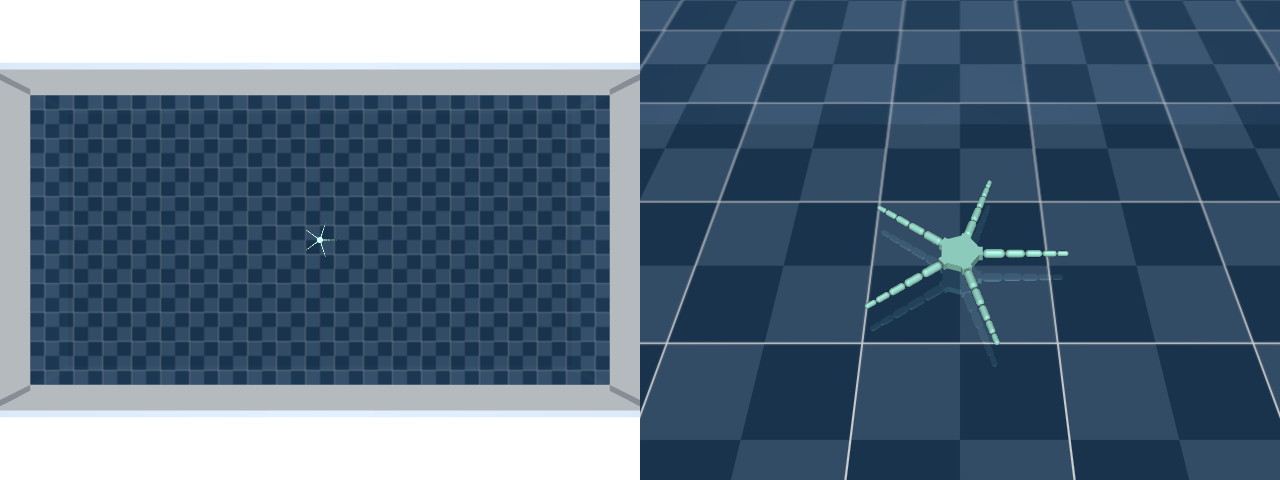

In [44]:
print("Observation space:")
print(f"\t{env.observation_space}")
print("Action space:")
print(f"\t{env.action_space}")
print("First 8 Actuators:")
print(f"\t{env.actuators[:8]}")
rng = jax.random.PRNGKey(0)
state = jit_reset(rng=rng)
media.show_image(post_render(env.render(state=state), environment_configuration=environment_configuration))

This brittle star robot has $50$ joints in total (2 per segment: one in-plane (IP) joint and one out-of-plane (OOP) joint), which all have the same range of motion (as demonstrated by `env.action_space`). Each joint is given an actuator that can control the joints position. For the in-plane joints, a positive position means that the segment will point leftwards (when looking at the segment from the central disc), and rightwards for a negative position. For the out-of-plane joints, a positive position means that the segment will point upwards and downwards for a negative position. 

### Generating circular motion
To produce simple rowing behaviour, we'll need to make the arms move in a circular motion. The simplest way to do so, would be to actuate the IP joint according to a cosine function, and the OOP joint according to a sine function:

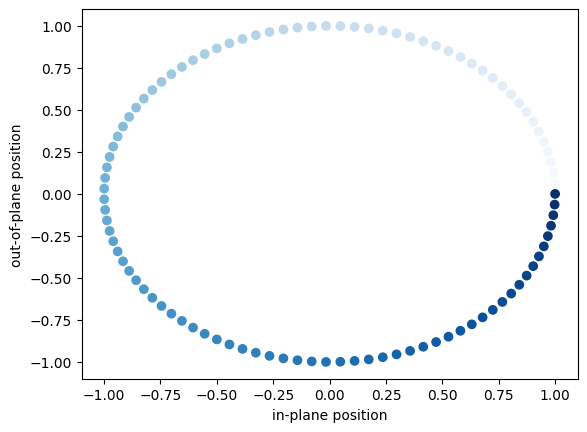

In [45]:
times = np.linspace(0, 2 * np.pi, 100)
in_plane_positions = np.cos(times)
out_of_plane_positions = np.sin(times)

plt.scatter(in_plane_positions, out_of_plane_positions, c=times, cmap="Blues")
plt.xlabel("in-plane position")
plt.ylabel("out-of-plane position")
plt.show()
plt.close()

This plot shows traversed IP and OOP positions (the time dimension is depicted by increasing brightness). 
Our CPG model however always uses the cosine of the phase (Equation (4)) to produce the output. Luckily, we can imitate a sine by a cosine by adding some phase bias to the cosine!:

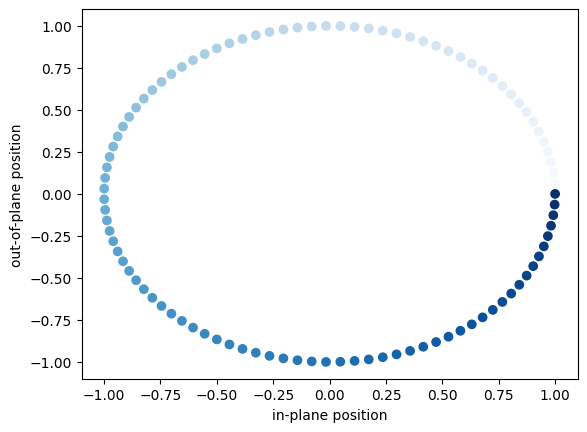

In [46]:
times = np.linspace(0, 2 * np.pi, 100)
in_plane_positions = np.cos(times)
out_of_plane_positions = np.cos(times - np.pi / 2)

plt.scatter(in_plane_positions, out_of_plane_positions, c=times, cmap="Blues")
plt.xlabel("in-plane position")
plt.ylabel("out-of-plane position")
plt.show()
plt.close()

Okay, so we know that we'll have to add a phase bias of $\frac{\pi}{2}$ between the IP and OOP oscillators.
If we were to imitate rowing behaviour with our own arms, however, we'll notice that our left arm traverses the circle in the clockwise direction, while our right arm moves in the counterclockwise direction. The above motion goes in the counterclockwise direction. Luckily, to get a clockwise direction, we just need to play with the phase bias again. Instead of subtracting $\frac{\pi}{2}$ from the OOP phase, we just need to add it.

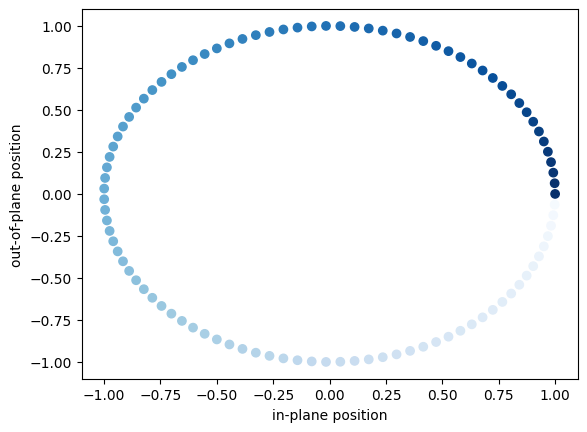

In [47]:
times = np.linspace(0, 2 * np.pi, 100)
in_plane_positions = np.cos(times)
out_of_plane_positions = np.cos(times + np.pi / 2)

plt.scatter(in_plane_positions, out_of_plane_positions, c=times, cmap="Blues")
plt.xlabel("in-plane position")
plt.ylabel("out-of-plane position")
plt.show()
plt.close()

### CPG setup
Now that we know how we can play with phase biases to produce circular motions in both the clockwise and counterclockwise directions, we can now implement our CPG system.
To simplify things, we will not use a distinct oscillator for every joint in the brittle star's morphology. Instead, we'll just use two bi-directionally connected oscillators per arm: one for the IP motion and one for the OOP motion. We can then just map the output of an oscillator to all its respective joints in the arm (i.e. the IP oscillator's output is mapped to all IP joints of that arm, and the same thing for the OOP oscillator and the OOP joints). Given that we have 5 arms and 2 oscillators per arm, we thus have a total of $5 \times 2 = 10$ oscillators. To make sure different arms stay synchronized, we will couple the IP oscillator of one arm to the IP oscillators of its neighbouring arms, and do the same thing for the OOP oscillators.

![](https://github.com/Co-Evolve/SEL3-2024/blob/develop/tutorials/assets/brittle_star_cpg.png?raw=true)

In [48]:
def create_cpg() -> CPG:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    adjacency_matrix = jnp.zeros((10, 10))
    # Connect oscillators within an arm
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)
    # Connect IP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[
        ip_oscillator_indices, jnp.concatenate((ip_oscillator_indices[1:], jnp.array([ip_oscillator_indices[0]])))].set(
            1
            )
    # Connect OOP oscillators of neighbouring arms
    adjacency_matrix = adjacency_matrix.at[oop_oscillator_indices, jnp.concatenate(
            (oop_oscillator_indices[1:], jnp.array([oop_oscillator_indices[0]]))
            )].set(1)

    # Make adjacency matrix symmetric (i.e. make all connections bi-directional)
    adjacency_matrix = jnp.maximum(adjacency_matrix, adjacency_matrix.T)
    # Connect oscillators within an arm
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)

    return CPG(
            weights=5 * adjacency_matrix,
            amplitude_gain=20,
            offset_gain=20,
            dt=environment_configuration.control_timestep
            )

A [brittle star's rowing gait](https://www.youtube.com/watch?v=X8UEST-flCM) divides the arms in roughly two roles: (1) one leading arm that points towards the direction of motion, and (2) rowers that pull the brittle star forwards. We will try to module our CPG in such a way that we can reproduce this behaviour.
For the leading arm, this comes down to:
- Setting its IP and OOP oscillator's amplitude $R$ to zero in order to inhibit oscillatory motion.
    - Given that we inhibit the leading arms oscillatory motions, we can just set its coupling phase biases to zero as well.
- Settings the offset $X$ of its IP oscillator to zero to make it point forwards.
- Settings the offset $X$ if its OOP oscillator to a positive value to make it point upwards. This will avoid the leading arm sliding on the ground and creating unnecessary friction.

For the rowers, it is a bit more complex:
- We will set their amplitudes $R$ to the maximum joint range of motion.
- We will set their IP and OOP offset $X$ to zero to make oscillations center around zero.
- We will set their coupling phase biases $\rho$ in such a way that their IP and OOP oscillators produce a circular motion of the arm. As discussed above, can be done by incorporating a phase bias of $\frac{\pi}{2}$ between the IP and OOP oscillator.
    - Arms on the right of the leading arm will need to follow a counterclockwise direction, while arms on the left of the leading arm need to follow a clockwise direction.
    - Let's say that for some rowing arm, our IP oscillator has index $i$ and our OOP oscillator has index $j$:
        - To create a counterclockwise motion, the above test shows that we need $\phi_{j} = \phi_{i} - \frac{\pi}{2}$. This means that we'll need to set $\rho_{ij} = -\frac{\pi}{2}$ and $\rho_{ji} = \frac{\pi}{2}$. (If this confuses you, take another look at our very first CPG test and its corresponding phase plot.)
        - To create a clockwise motion, the above test shows that we need $\phi_{j} = \phi_{i} + \frac{\pi}{2}$. This means that we'll need to set $\rho_{ij} = \frac{\pi}{2}$ and $\rho_{ji} = -\frac{\pi}{2}$.

Since we connected the oscillators of neighbouring arms, we also need to double-check if these couplings require phase bias adaptations (as discussed in the explanation of the CPG model, we always want to ensure that all phase biases in a loop are consistent: they must sum to a multiple of $2\pi$):
- Phase biases of coupling's between the IP oscillators of the left rowers can be set to zero: we always want them to be completely in-sync.
- Phase biases of coupling's between the IP oscillators of the right rowers can be set to zero: we always want them to be completely in-sync.
- Phase biases of coupling's between the IP oscillators of a left and right rower can not be set to zero: they will need a phase bias of $\pi$ as they were both shifted by $\frac{\pi}{2}$ in opposite directions due to the phase bias of the coupling with their respective OOP oscillators. In other words, without adaptation, this loop would have a phase bias sum of $\frac{\pi}{2} + \frac{\pi}{2} = \pi$.
- All the coupling's phase biases between OOP oscillators of neighbouring arms can be set to zero: we always want them to be completely in-sync as we for instance never want one arm going down while the others are going up.
    - However, the coupling between oscillators of the leading arm and its neighbouring (rowing arms) presents an edge case. We have set the phase biases of the leading arm's oscillators to zero, while the neighbouring rowers will have non-zero phase biases between their IP and OOP oscillators. If we would just set the phase biases between the leading arm's oscillators and the neighbouring (rowing) arm's IP and OOP oscillators to zero, we get a mismatch! The leading arm's IP and OOP oscillators will try to be in-phase with each other, while also trying to be in-phase with the IP and OOP oscillators of the neighbouring arms which are out-of-phase. Luckily, as we set the amplitudes $R$ of our leading arm to zero, this mismatch would cause no harm. The change in phase frequency $\dot\phi_i$ that a coupling's phase bias $\rho_{ij}$ can induce (Equation (1)) is scaled by the amplitude of the incoming oscillator $r_j$. Consequently, our rower's oscillators won't be influenced. Nevertheless, we'll protect ourselves from strange bugs that this issue might cause at a later stage (e.g. if we would use non-zero amplitudes for the leading arm) and fix this mismatch. Let's say that our leading arm's IP oscillator has index $x$ and its OOP oscillator has index $y$. As we have no phase bias between them, we need to make sure that $\phi_{x} = \phi_{y}$.
        - For the first arm to the left of the leading arm (with IP oscillator index $i$ and OOP oscillator index $j$), we have set the phase biases such that we get $\phi_{j} = \phi_{i} + \frac{\pi}{2}$ to produce a clockwise circular motion.
            - To fix the mismatch between the IP oscillators $x$ and $i$, we need to set their coupling's phase bias such that $\phi_{x} = \phi_{i} + \frac{\pi}{4}$. This means that we'll need to set $\rho_{ix} = \frac{\pi}{4}$ and $\rho_{xi} = -\frac{\pi}{4}$.
            - To fix the mismatch between the OOP oscillators $y$ and $j$, we need to set their coupling's phase bias such that $\phi_{y} = \phi_{j} - \frac{\pi}{4}$. This means that we'll need to set $\rho_{iy} = -\frac{\pi}{4}$ and $\rho_{yi} = \frac{\pi}{4}$
            - This works because we have $\phi_{j} = \phi_{i} + \frac{\pi}{2}$, which we can rewrite as $\phi_{y} + \frac{\pi}{4} = \phi_{x} - \frac{\pi}{4} + \frac{\pi}{2}$, which gives us $\phi_y = \phi_x$ 
        - Similarly, for the first arm to the right of the leading arm (with IP oscillator index $i$ and OOP oscillator index $j$), we have set the phase biases such that we get $\phi_{j} = \phi_{i} - \frac{\pi}{2}$ to produce a counterclockwise circular motion.
            - To fix the mismatch between the IP oscillators $x$ and $i$, we need to set their coupling's phase bias such that $\phi_{x} = \phi_{i} - \frac{\pi}{4}$. This means that we'll need to set $\rho_{ix} = -\frac{\pi}{4}$ and $\rho_{xi} = \frac{\pi}{4}$
            - To fix the mismatch between the OOP oscillators $y$ and $j$, we need to set their coupling's phase bias such that $\phi_{y} = \phi_{j} + \frac{\pi}{4}$. This means that we'll need to set $\rho_{iy} = \frac{\pi}{4}$ and $\rho_{yi} = -\frac{\pi}{4}$


Note: It might be a bit tough to understand the reasoning behind the choices of phase biases and especially whether $\rho_{ij}$ or $\rho_{ji}$ should be negative. Whenever in doubt: play some more with the simple 2-oscillator model from above and look at the corresponding phase plot!   
Note: The reason that we can come up with this kind of modulation that produces some desired gait is because we know the closed form solution of our CPG model.

In [49]:
from functools import partial
from mujoco_utils.environment import mjx_spaces
from typing import Tuple


def get_oscillator_indices_for_arm(
        arm_index: int
        ) -> Tuple[int, int]:
    return arm_index * 2, arm_index * 2 + 1


@jax.jit
def modulate_cpg(
        cpg_state: CPGState,
        leading_arm_index: int,
        max_joint_limit: float
        ) -> CPGState:
    left_rower_arm_indices = [(leading_arm_index - 1) % 5, (leading_arm_index - 2) % 5]
    right_rower_arm_indices = [(leading_arm_index + 1) % 5, (leading_arm_index + 2) % 5]

    leading_arm_ip_oscillator_index, leading_arm_oop_oscillator_index = get_oscillator_indices_for_arm(
            arm_index=leading_arm_index
            )

    R = jnp.zeros_like(cpg_state.R)
    X = jnp.zeros_like(cpg_state.X)
    rhos = jnp.zeros_like(cpg_state.rhos)
    omegas = jnp.pi * jnp.ones_like(cpg_state.omegas)
    phases_bias_pairs = []

    def modulate_leading_arm(
            _X: jnp.ndarray,
            _arm_index: int
            ) -> jnp.ndarray:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        return _X.at[oop_oscillator_index].set(max_joint_limit)

    def modulate_left_rower(
            _R: jnp.ndarray,
            _arm_index: int
            ) -> Tuple[jnp.ndarray, List[Tuple[int, int, float]]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _R = _R.at[ip_oscillator_index].set(max_joint_limit)
        _R = _R.at[oop_oscillator_index].set(max_joint_limit)
        _phase_bias_pairs = [(ip_oscillator_index, oop_oscillator_index, jnp.pi / 2)]
        return _R, _phase_bias_pairs

    def phase_biases_first_left_rower(
            _arm_index: int
            ) -> List[Tuple[int, int, float]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _phase_bias_pairs = [(ip_oscillator_index, leading_arm_ip_oscillator_index, jnp.pi / 4),
                             (leading_arm_oop_oscillator_index, oop_oscillator_index, jnp.pi / 4)]
        return _phase_bias_pairs

    def modulate_right_rower(
            _R: jnp.ndarray,
            _arm_index: int
            ) -> Tuple[jnp.ndarray, List[Tuple[int, int, float]]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _R = _R.at[ip_oscillator_index].set(max_joint_limit)
        _R = _R.at[oop_oscillator_index].set(max_joint_limit)
        _phase_bias_pairs = [(oop_oscillator_index, ip_oscillator_index, jnp.pi / 2)]
        return _R, _phase_bias_pairs

    def phase_biases_first_right_rower(
            _arm_index: int
            ) -> List[Tuple[int, int, float]]:
        ip_oscillator_index, oop_oscillator_index = get_oscillator_indices_for_arm(arm_index=_arm_index)
        _phase_bias_pairs = [(leading_arm_ip_oscillator_index, ip_oscillator_index, jnp.pi / 4),
                             (oop_oscillator_index, leading_arm_oop_oscillator_index, jnp.pi / 4)]
        return _phase_bias_pairs

    def phase_biases_second_rowers(
            _left_arm_index: int,
            _right_arm_index: int
            ) -> List[Tuple[int, int, float]]:
        left_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=_left_arm_index)
        right_ip_oscillator_index, _ = get_oscillator_indices_for_arm(arm_index=_right_arm_index)
        _phase_bias_pairs = [(left_ip_oscillator_index, right_ip_oscillator_index, jnp.pi)]
        return _phase_bias_pairs

    X = modulate_leading_arm(_X=X, _arm_index=leading_arm_index)

    R, phb = modulate_left_rower(_R=R, _arm_index=left_rower_arm_indices[0])
    phases_bias_pairs += phb

    R, phb = modulate_left_rower(_R=R, _arm_index=left_rower_arm_indices[1])
    phases_bias_pairs += phb

    R, phb = modulate_right_rower(_R=R, _arm_index=right_rower_arm_indices[0])
    phases_bias_pairs += phb

    R, phb = modulate_right_rower(_R=R, _arm_index=right_rower_arm_indices[1])
    phases_bias_pairs += phb

    phases_bias_pairs += phase_biases_first_left_rower(_arm_index=left_rower_arm_indices[0])
    phases_bias_pairs += phase_biases_first_right_rower(_arm_index=right_rower_arm_indices[0])

    phases_bias_pairs += phase_biases_second_rowers(
            _left_arm_index=left_rower_arm_indices[1], _right_arm_index=right_rower_arm_indices[1]
            )

    for oscillator1, oscillator2, bias in phases_bias_pairs:
        rhos = rhos.at[oscillator1, oscillator2].set(bias)
        rhos = rhos.at[oscillator2, oscillator1].set(-bias)

    # noinspection PyUnresolvedReferences
    return cpg_state.replace(
            R=R, X=X, rhos=rhos, omegas=omegas
            )

Before moving on, let's first do a validity check and plot our cpg outputs over some time:

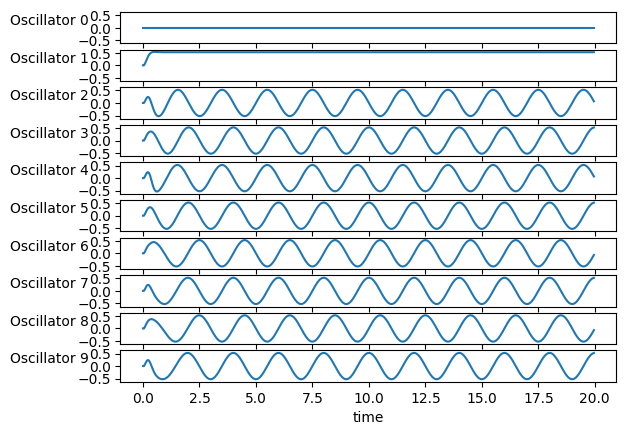

In [50]:
cpg = create_cpg()
cpg_state = cpg.reset(rng=jax.random.PRNGKey(seed=0))
cpg_state = modulate_cpg(cpg_state=cpg_state, leading_arm_index=0, max_joint_limit=env.action_space.high[0])

times = []
outputs = []
while cpg_state.time < environment_configuration.simulation_time:
    outputs.append(cpg_state.outputs)
    times.append(cpg_state.time)
    cpg_state = cpg.step(
            state=cpg_state
            )

import matplotlib.gridspec as gridspec

outputs_per_oscillator = np.array(outputs).T
gs = gridspec.GridSpec(int(cpg.num_oscillators), 1)
fig = plt.figure()

for i, outputs in enumerate(outputs_per_oscillator):
    ax = fig.add_subplot(gs[i])
    ax.plot(times, outputs)
    ax.set_ylabel(f"Oscillator {i}", rotation=0, labelpad=20)
    ax.set_ylim(env.action_space.low[0] - 0.1, env.action_space.high[1] + 0.1)
    if i < outputs_per_oscillator.shape[0] - 1:
        plt.tick_params(
                axis='x', labelbottom='off'
                )

plt.xlabel("time")
plt.show()
plt.show()
plt.close()

Try to validate its correctness based on the rules that we implemented.

Now we'll need to implement a helper function that maps our CPG's outputs to an actual action array. As stated above, we have two oscillators per arm, one for all in-plane motions within that arm and one for all out-of-plane motions for within that arm.

In [51]:
@jax.jit
def map_cpg_outputs_to_actions(
        cpg_state: CPGState
        ) -> jnp.ndarray:
    num_arms = 5
    num_oscillators_per_arm = 2
    num_segments_per_arm = 5

    cpg_outputs_per_arm = cpg_state.outputs.reshape((num_arms, num_oscillators_per_arm))
    cpg_outputs_per_segment = cpg_outputs_per_arm.repeat(num_segments_per_arm, axis=0)

    actions = cpg_outputs_per_segment.flatten()
    return actions

Now we can finally apply it to the actual brittle star:

In [52]:
cpg = create_cpg()
cpg_state = cpg.reset(rng=jax.random.PRNGKey(0))
cpg_state = modulate_cpg(cpg_state=cpg_state, leading_arm_index=0, max_joint_limit=env.action_space.high[0])

done = False
frames = []
env_state = jit_reset(rng=jax.random.PRNGKey(seed=0))
while not (env_state.terminated | env_state.truncated):
    cpg_state = cpg.step(state=cpg_state)
    actions = map_cpg_outputs_to_actions(cpg_state=cpg_state)
    env_state = jit_step(state=env_state, action=actions)
    frame = post_render(env.render(state=env_state), environment_configuration=environment_configuration)
    frames.append(frame)
show_video(images=frames)

Looks good! Let's see if we can change the leading arm at half the simulation time.

In [53]:
cpg_state = cpg.reset(rng=jax.random.PRNGKey(0))
cpg_state = modulate_cpg(cpg_state=cpg_state, leading_arm_index=0, max_joint_limit=env.action_space.high[0])

done = False
frames = []
env_state = jit_reset(rng=jax.random.PRNGKey(seed=0))
remodulated = False
while not (env_state.terminated | env_state.truncated):
    cpg_state = cpg.step(state=cpg_state)
    actions = map_cpg_outputs_to_actions(cpg_state=cpg_state)
    env_state = jit_step(state=env_state, action=actions)
    frame = post_render(env.render(state=env_state), environment_configuration=environment_configuration)
    frames.append(frame)

    if not remodulated and state.info["time"] > environment_configuration.simulation_time / 2:
        cpg_state = modulate_cpg(cpg_state=cpg_state, leading_arm_index=2, max_joint_limit=env.action_space.high[0])
        remodulated = True
show_video(images=frames)

Awesome, by exploiting our prior knowledge on brittle star rowing behaviour and by making simplifications in our CPG system, we can manually define quite a decent gait for our brittle star robot! In applications where we cannot manually define the modulation parameters, we often apply optimization algorithms to solve this problem for us. For instance, we can optimize the modulation parameters to make the robot crawl as fast as possible or even to try to discover as many distinct gaits as possible. Optimization also allows us to scale up the number of oscillators (e.g. to the number of actuators). This gives the CPG more degrees of freedom to work with, allowing it to produce more complex behaviours than our current circular motions.

## Excercises
1. Now that we have found the modulation parameters that produce rowing behaviour, try to adapt the modulation parameters to produce reverse rowing behaviour.
2. Try to apply the rowing gait to solve the targeted locomotion task. Every $n$ timesteps, you can do a check which arm is closest to the target. Then you can remodulate the CPG to make that arm the leading arm.

## Reading material (optional)
- [Ijspeert, 2008, Central pattern generators for locomotion control in animals and robots: a review, Neural Networks](https://www.sciencedirect.com/science/article/pii/S0893608008000804)
- [Sproewitz et al., 2008, Learning to move in modular robots using CPGs and online optimization, Int. J. Robotics Res.](https://journals.sagepub.com/doi/10.1177/0278364907088401)
- [Buchli et al., 2006, Engineering entrainment and adaptation in limit cycle systems, Biol. Cybern.](https://pubmed.ncbi.nlm.nih.gov/17146662/)
- [Ijspeert et al., 2007, From swimming to walking with a salamander robot driven by a spinal cord model, Science](https://www.science.org/doi/10.1126/science.1138353)